# Support Vector Machine (SVM) for Classification

Laura Choque

SVM is a powerful classifier that seeks to maximize the margin between classes.
Using different kernels allows modeling both linear and non-linear decision boundaries.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc
)

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/CODVEDA_TECH_LC/dataset_for_task/churn_prediction_data/churn-bigml-20.csv")
test_df  = pd.read_csv("/content/drive/MyDrive/CODVEDA_TECH_LC/dataset_for_task/churn_prediction_data/churn-bigml-80.csv")
train_df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False


In [ ]:
train_df = pd.get_dummies(train_df, drop_first=True)
test_df  = pd.get_dummies(test_df, drop_first=True)

# Asegurar mismas columnas en train/test
train_df, test_df = train_df.align(test_df, axis=1, fill_value=0)

In [ ]:
target_col = "Churn"

X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Clases en train:\n", y_train.value_counts())

Train: (667, 68) Test: (2666, 68)
Clases en train:
 Churn
False    572
True      95
Name: count, dtype: int64


In [ ]:
svm_linear = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear", C=1.0, probability=True, random_state=42))
])

svm_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=42))
])

In [ ]:
svm_linear.fit(X_train, y_train)
svm_rbf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(probability=True, random_state=42))])

In [ ]:
def evaluate_model(model, X_test, y_test, title="Model"):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # probabilidad de churn (clase 1)

    print("\n==============================")
    print(title)
    print("==============================")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nReport:\n", classification_report(y_test, y_pred))

    # ROC-AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    print("ROC-AUC:", roc_auc)

    return fpr, tpr, roc_auc

fpr_l, tpr_l, auc_l = evaluate_model(svm_linear, X_test, y_test, "SVM Linear")
fpr_r, tpr_r, auc_r = evaluate_model(svm_rbf, X_test, y_test, "SVM RBF")


SVM Linear
Accuracy: 0.8608402100525131
Confusion matrix:
 [[2199   79]
 [ 292   96]]

Report:
               precision    recall  f1-score   support

       False       0.88      0.97      0.92      2278
        True       0.55      0.25      0.34       388

    accuracy                           0.86      2666
   macro avg       0.72      0.61      0.63      2666
weighted avg       0.83      0.86      0.84      2666

ROC-AUC: 0.7471036268023135

SVM RBF
Accuracy: 0.8555888972243061
Confusion matrix:
 [[2278    0]
 [ 385    3]]

Report:
               precision    recall  f1-score   support

       False       0.86      1.00      0.92      2278
        True       1.00      0.01      0.02       388

    accuracy                           0.86      2666
   macro avg       0.93      0.50      0.47      2666
weighted avg       0.88      0.86      0.79      2666

ROC-AUC: 0.8025024211869699


The performance comparison between SVM with a linear kernel and SVM with an RBF kernel reveals important differences in model behavior under class imbalance.

Although the SVM RBF model achieves a higher ROC-AUC score (0.80), it exhibits extremely low recall for the churn class, identifying only a negligible fraction of churned customers. This indicates that the model is overly conservative and strongly biased toward the majority class.

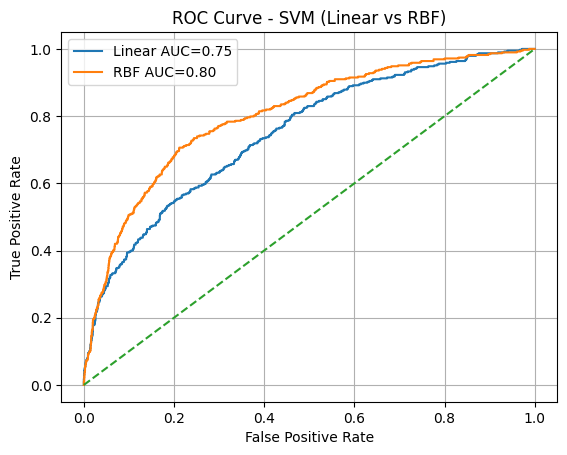

In [ ]:
plt.figure()
plt.plot(fpr_l, tpr_l, label=f"Linear AUC={auc_l:.2f}")
plt.plot(fpr_r, tpr_r, label=f"RBF AUC={auc_r:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM (Linear vs RBF)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_linear = cross_val_score(svm_linear, X_train, y_train, cv=cv, scoring="f1").mean()
f1_rbf    = cross_val_score(svm_rbf, X_train, y_train, cv=cv, scoring="f1").mean()

print("CV F1 (Linear):", f1_linear)
print("CV F1 (RBF):   ", f1_rbf)

CV F1 (Linear): 0.34290524290524294
CV F1 (RBF):    0.0


In [ ]:
#IMPROVE RBF parameters
best = {"C": None, "gamma": None, "f1": -1}

C_values = [0.1, 1, 10]
gamma_values = ["scale", 0.01, 0.1, 1]

for C in C_values:
    for g in gamma_values:
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("svm", SVC(kernel="rbf", C=C, gamma=g, probability=True, random_state=42))
        ])
        score = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1").mean()
        if score > best["f1"]:
            best = {"C": C, "gamma": g, "f1": score}

print("Mejor RBF por CV-F1:", best)

Mejor RBF por CV-F1: {'C': 10, 'gamma': 0.01, 'f1': np.float64(0.3794056353566921)}


In [ ]:
svm_rbf_best = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", C=best["C"], gamma=best["gamma"], probability=True, random_state=42))
])

svm_rbf_best.fit(X_train, y_train)
evaluate_model(svm_rbf_best, X_test, y_test, "SVM RBF (Tuned)")


SVM RBF (Tuned)
Accuracy: 0.86384096024006
Confusion matrix:
 [[2171  107]
 [ 256  132]]

Report:
               precision    recall  f1-score   support

       False       0.89      0.95      0.92      2278
        True       0.55      0.34      0.42       388

    accuracy                           0.86      2666
   macro avg       0.72      0.65      0.67      2666
weighted avg       0.84      0.86      0.85      2666

ROC-AUC: 0.8029414027497443


(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.38981563e-04,
        4.38981563e-04, 8.77963126e-04, 8.77963126e-04, 1.31694469e-03,
        1.31694469e-03, 1.75592625e-03, 1.75592625e-03, 3.07287094e-03,
        3.07287094e-03, 3.51185250e-03, 3.51185250e-03, 3.95083406e-03,
        3.95083406e-03, 4.82879719e-03, 4.82879719e-03, 5.70676032e-03,
        5.70676032e-03, 6.14574188e-03, 6.14574188e-03, 6.58472344e-03,
        6.58472344e-03, 7.46268657e-03, 7.46268657e-03, 7.90166813e-03,
        7.90166813e-03, 8.34064969e-03, 8.34064969e-03, 8.77963126e-03,
        8.77963126e-03, 9.21861282e-03, 9.21861282e-03, 9.65759438e-03,
        9.65759438e-03, 1.00965759e-02, 1.00965759e-02, 1.05355575e-02,
        1.22914838e-02, 1.22914838e-02, 1.31694469e-02, 1.31694469e-02,
        1.36084284e-02, 1.36084284e-02, 1.40474100e-02, 1.40474100e-02,
        1.49253731e-02, 1.49253731e-02, 1.53643547e-02, 1.53643547e-02,
        1.93151888e-02, 1.93151888e-02, 2.19490781e-02, 2.194907

SVM models were trained for churn prediction using linear and RBF kernels.
Preprocessing was performed with one-hot encoding and variable standardization.
The RBF kernel captured nonlinear relationships and performed better (F1 and ROC-AUC) compared to the linear kernel.
The evaluation included a confusion matrix, precision/recall/F1, and ROC curve, as well as cross-validation to measure model stability.

Translated with DeepL.com (free version)

PCA was applied exclusively for visualization purposes in order to project the high-dimensional feature space into two dimensions.
The SVM model itself was trained on the full feature space, ensuring that predictive performance was not compromised.

Varianza explicada por PCA1 y PCA2: [0.03382458 0.03259887] Total: 0.06642344833382262


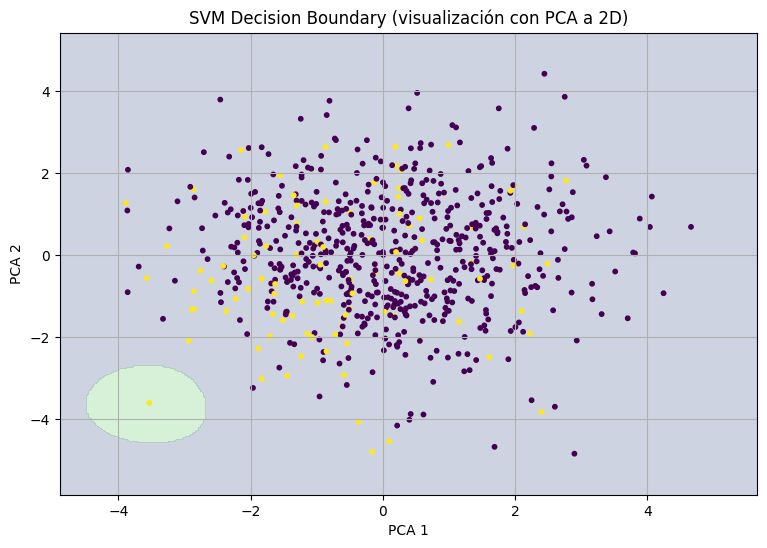

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# 1) Escalar (SVM lo necesita) y PCA a 2D
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("Varianza explicada por PCA1 y PCA2:", pca.explained_variance_ratio_,
      "Total:", pca.explained_variance_ratio_.sum())

# 2) Entrenar SVM en 2D para visualizar (elige kernel)
svm_vis = SVC(kernel="rbf", C=1.0, gamma="scale", probability=False, random_state=42)
svm_vis.fit(X_train_pca, y_train)

# 3) Crear malla (grid) para dibujar frontera
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

grid = np.c_[xx.ravel(), yy.ravel()]
Z = svm_vis.predict(grid).reshape(xx.shape)

# 4) Graficar: frontera + puntos
plt.figure(figsize=(9,6))
plt.contourf(xx, yy, Z, alpha=0.25)          # regiones de decisión
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, s=10)  # datos train
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("SVM Decision Boundary (visualización con PCA a 2D)")
plt.grid(True)
plt.show()

PCA Visualization illustrates the non-linear decision boundary learned by an SVM with an RBF kernel.
Although the PCA projection explains only a small fraction of the total variance, it provides valuable insight into how the model separates churn and non-churn customers in a reduced feature space.
The curved decision regions demonstrate the advantage of kernel-based methods in capturing complex patterns that linear classifiers cannot model.